In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy 
import pandas as pd
import tensorflow as tf
import tensorflow_probability as tfp

from keras import layers, Sequential

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

# DATA SPLITTING FOR MACHINE LEARNING

In [2]:
#Dataframe Structure
#  Time (fs) /// E_1 /// E_2 ....................... /// E_m
# -100       /// xxx /// xxx ....................... /// xxx
# ...        /// xxx /// xxx ....................... /// xxx
# 100        /// xxx /// xxx ....................... /// xxx

#Selecting data from data frame
df_time        = pd.read_csv('clean_data.csv', sep=' ') 
df_time_noisy  = pd.read_csv('noisy_data.csv', sep=' ')


X              = df_time_noisy.drop(columns='Time (fs)')
y              = df_time.drop(columns='Time (fs)')

# print('X values before augmentation:', X.shape)


#Augmenting data
# Adding data scaled by random factor
for i in range(1, 7):
    fac        = np.random.rand(1)
    Xran       = X.apply(lambda x: i*fac*x, axis=1)
    yran       = y.apply(lambda x: i*fac*x, axis=1)    
    X          = pd.concat([X, Xran], axis=1)
    y          = pd.concat([y, yran], axis=1)

#Transposing Data, each row becomes an example E_m
X              = X.transpose().astype('float64')
y              = y.transpose().astype('float64')

#Splitting the dataset into the training set and test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, shuffle=True)#, random_state = 0)

#x.shape will return a tuple (m, n), where m is the number of rows, and n is the number of columns.
# print('X values (examples m, Em):', X.shape, X_train.shape, X_test.shape)
# print('y values:', y.shape, y_train.shape, y_test.shape)
# print('time len:', df_time['Time (fs)'].shape)



#Feature scaling by normalising in the range from -1 to 1 (min-max)
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, Normalizer, MaxAbsScaler, normalize

scxx     = MaxAbsScaler()
X_train  = scxx.fit_transform(normalize(X_train))
X_test   = scxx.transform(normalize(X_test))

scyy     = MaxAbsScaler()
y_train  = scyy.fit_transform(normalize(y_train))
y_test   = scyy.transform(normalize(y_test))

#Reshape data for Conv1D
X_train = np.reshape(X_train[:], (len(X_train),len(df_time['Time (fs)'])))
y_train = np.reshape(y_train[:], (len(X_train),len(df_time['Time (fs)'])))

# print(X_train.shape, y_train.shape, X_test.shape)

X values before augmentation: (1000, 1000)
X values (examples m, Em): (64000, 1000) (57600, 1000) (6400, 1000)
y values: (64000, 1000) (57600, 1000) (6400, 1000)
time len: (1000,)


# 1D CONVOLUTIONAL AUTOENCODER

In [3]:
def Conv1D_Model():
    #Shape = (batch_size = no. examples = len(X_train), time_steps = no. features, input_dimension = 1D vector)
    x = tf.keras.Sequential()
    x.add(layers.Input(shape=(len(df_time['Time (fs)']), 1)))

    x.add(layers.Conv1D(32, 3, activation="tanh", padding="same"))
    x.add(layers.MaxPooling1D(2, padding="same"))
    x.add(layers.Conv1D(64, 3, activation="tanh", padding="same"))
    x.add(layers.MaxPooling1D(2, padding="same"))
    
    x.add(layers.Dropout(0.2))
    
    x.add(layers.Conv1DTranspose(64, 3, activation="tanh", padding="same"))    
    x.add(layers.Conv1DTranspose(32, 3, activation="tanh", padding="same"))  
    x.add(layers.Conv1DTranspose(4, 3, activation="tanh", padding="same"))
    
    x.add(layers.Flatten())
    x.add(tf.keras.layers.Dense(1000, activation='tanh', use_bias=True))

    x.compile(optimizer="adam", loss='mean_squared_error', metrics=tf.keras.metrics.RootMeanSquaredError())

    return x


autoencoder = Conv1D_Model()
autoencoder.summary()

# early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15)

2023-08-29 08:42:47.234910: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-08-29 08:42:47.235495: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1 Pro
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 1000, 32)          128       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 500, 32)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 500, 64)           6208      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 250, 64)          0         
 1D)                                                             
                                                                 
 dropout (Dropout)           (None, 250, 64)           0         
                                                                 
 conv1d_transpose (Con

# FITTING MODEL

In [4]:
# LOADING MODEL
# from tensorflow import keras
# autoencoder = keras.models.load_model('/PATH/Model_Name_And_Details')

# FITTING MODEL
history = autoencoder.fit(X_train, y_train, batch_size=128, epochs=100, validation_split=0.2, callbacks=None, shuffle=True, verbose=2)

Epoch 1/100


2023-08-29 08:43:37.913573: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-08-29 08:43:38.204199: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-29 08:43:43.407754: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


360/360 - 6s - loss: 0.0040 - root_mean_squared_error: 0.0635 - val_loss: 0.0012 - val_root_mean_squared_error: 0.0340 - 6s/epoch - 16ms/step
Epoch 2/100
360/360 - 5s - loss: 9.3674e-04 - root_mean_squared_error: 0.0306 - val_loss: 5.8420e-04 - val_root_mean_squared_error: 0.0242 - 5s/epoch - 13ms/step
Epoch 3/100
360/360 - 4s - loss: 6.3144e-04 - root_mean_squared_error: 0.0251 - val_loss: 4.1900e-04 - val_root_mean_squared_error: 0.0205 - 4s/epoch - 12ms/step
Epoch 4/100
360/360 - 4s - loss: 5.1676e-04 - root_mean_squared_error: 0.0227 - val_loss: 3.4390e-04 - val_root_mean_squared_error: 0.0185 - 4s/epoch - 12ms/step
Epoch 5/100
360/360 - 4s - loss: 4.5276e-04 - root_mean_squared_error: 0.0213 - val_loss: 2.9282e-04 - val_root_mean_squared_error: 0.0171 - 4s/epoch - 12ms/step
Epoch 6/100
360/360 - 5s - loss: 4.0614e-04 - root_mean_squared_error: 0.0202 - val_loss: 2.5944e-04 - val_root_mean_squared_error: 0.0161 - 5s/epoch - 14ms/step
Epoch 7/100
360/360 - 5s - loss: 3.7150e-04 - ro

# MODEL PERFORMANCE PLOT

dict_keys(['loss', 'root_mean_squared_error', 'val_loss', 'val_root_mean_squared_error'])


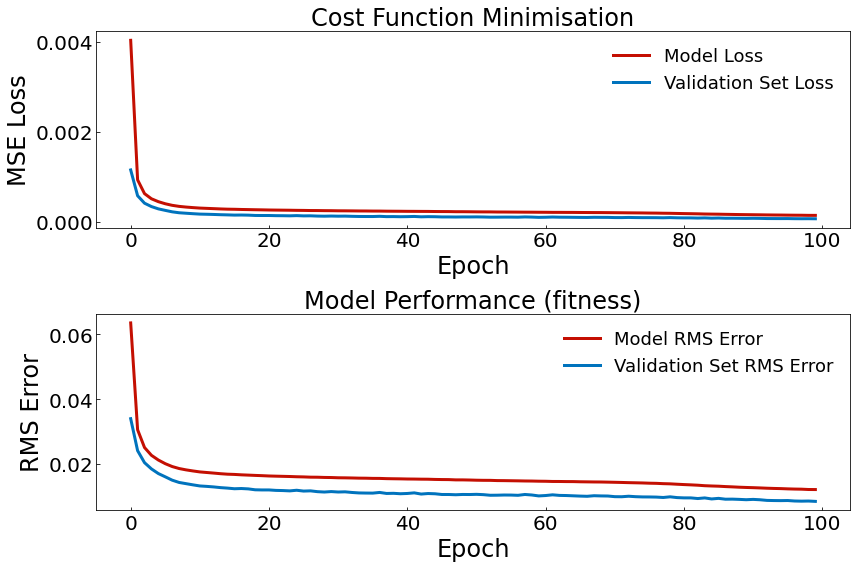

In [5]:
print(history.history.keys())

fig, axs = plt.subplots(2, 1, sharex=False, figsize=(12,8))

axs[0].plot(history.history['loss'], linewidth=3, color='#C40F02')
axs[0].plot(history.history['val_loss'], linewidth=3, color='#0073BD')
axs[0].legend(['Model Loss', 'Validation Set Loss'],fontsize=18, loc='best', frameon=False)
axs[0].set_xlabel('Epoch', fontsize=24)
axs[0].set_ylabel('MSE Loss', fontsize=24)
axs[0].tick_params('both', labelsize=20, direction='in')
axs[0].set_title('Cost Function Minimisation', fontsize=24)


axs[1].plot(history.history['root_mean_squared_error'], linewidth=3, color='#C40F02')
axs[1].plot(history.history['val_root_mean_squared_error'], linewidth=3, color='#0073BD')
axs[1].legend(['Model RMS Error', 'Validation Set RMS Error'],fontsize=18, loc='best', frameon=False)
axs[1].set_xlabel('Epoch', fontsize=24)
axs[1].set_ylabel('RMS Error', fontsize=24)
axs[1].tick_params('both', labelsize=20, direction='in')
axs[1].set_title('Model Performance (fitness)', fontsize=24)

plt.tight_layout()
plt.show()

# SAVE MODEL

In [ ]:
# autoencoder.save('Model_Name_And_Details')

# REVERTING DATA

In [8]:
#Reverting the data to the originale scale (after feature scalaing)
X_train_reverted = scxx.inverse_transform(np.reshape(X_train[:], (len(X_train),1000)))
y_train_reverted = scyy.inverse_transform(np.reshape(y_train[:], (len(y_train),1000)))

#To compare CNN performance with actual test value, we use CNN to predict what y would be based on X_test
X_test           = np.reshape(X_test[:], (len(X_test), len(df_time['Time (fs)']), 1))
y_pred           = autoencoder.predict(X_test)

#Revert test data and y_pred to original scale
#THIS IS TEST DATA REVERTED
X_test_reverted  = scxx.inverse_transform(np.reshape(X_test[:], (len(X_test),1000)))
y_pred_reverted = scyy.inverse_transform(y_pred[:])
y_test_reverted  = scyy.inverse_transform(y_test)

200/200 [==============================] - 1s 3ms/step


# PLOT OF NOISY DATA VS CLEAN DATA (NO FITTING FROM THE MODEL YET)

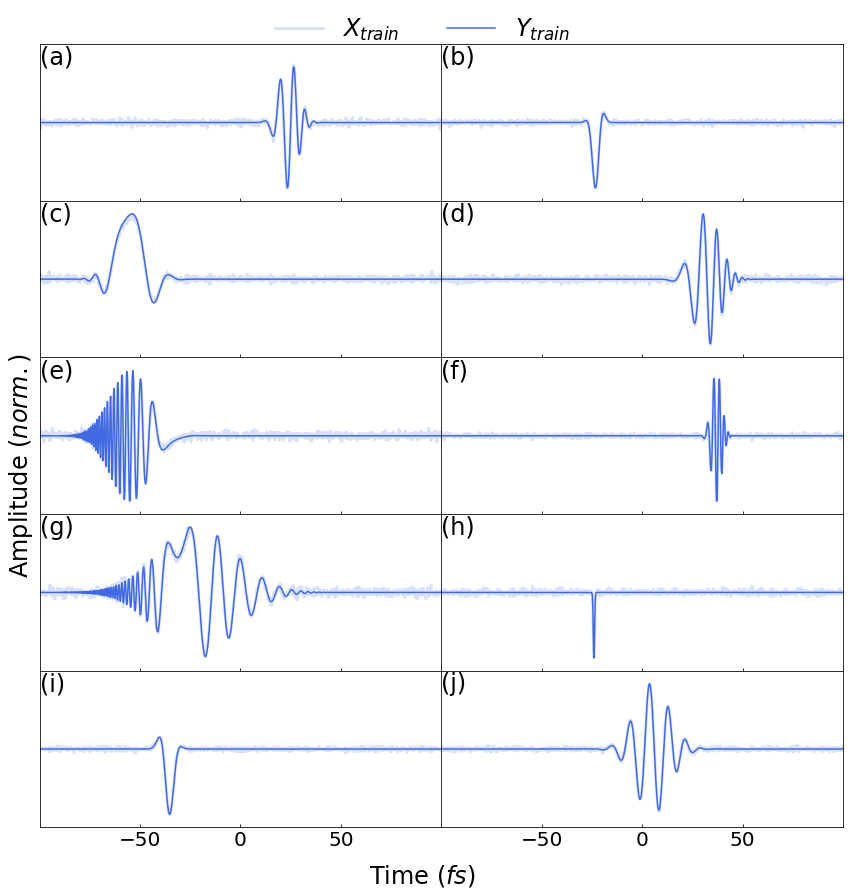

In [9]:
def norm(num):
    """
    03-08-2022
    
    This function normalises whatever you put into it.
    
    """
    import numpy as np

    return num/np.max(np.abs(num))


fig, axs = plt.subplots(5, 2, figsize=(12,12), sharex=True, sharey=True, gridspec_kw = {'wspace':0, 'hspace':0})


import random
from matplotlib.ticker import FormatStrFormatter

axs = axs.ravel()

for i in range(10):
    j = random.choice(range(len(y_pred_reverted)))
    axs[i].plot(df_time['Time (fs)'], norm(X_train_reverted[j, :].transpose()), linewidth=3, color='royalblue', alpha=0.2)
    axs[i].plot(df_time['Time (fs)'], norm(y_train_reverted[j, :].transpose()), linestyle='-',linewidth=1.5, color='royalblue')
    axs[i].set_xlim(-100,100)
    axs[i].tick_params('both', labelsize=20, direction='in')
    axs[i].yaxis.set_major_formatter(FormatStrFormatter('%1.1f'))
    
    fig_title = ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)', '(g)', '(h)', '(i)', '(j)']
    axs[i].set_title(fig_title[i], fontsize=24, loc='left', y=1.0, pad=-20)
    
fig.supylabel('Amplitude ($norm.$)', fontsize=24)
plt.ylim(-1.2,1.2)
fig.supxlabel('Time ($fs$)', fontsize=24)

plt.xticks([-50,0,50])
plt.yticks([])

    
fig.legend(['$X_{train}$', '$Y_{train}$'], loc='upper center', bbox_to_anchor=(0.5, 1.045), frameon=False, fontsize=24, ncol=2)

plt.tight_layout()
plt.show()

# PLOT OF MODEL PERFOMANCE AT DENOISING

/var/folders/l2/zgmv_2g55wbf1wpzk7lhns_w0000gn/T/ipykernel_15167/1123535929.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].set_xticklabels([-100, -50, 0, 50, 100])


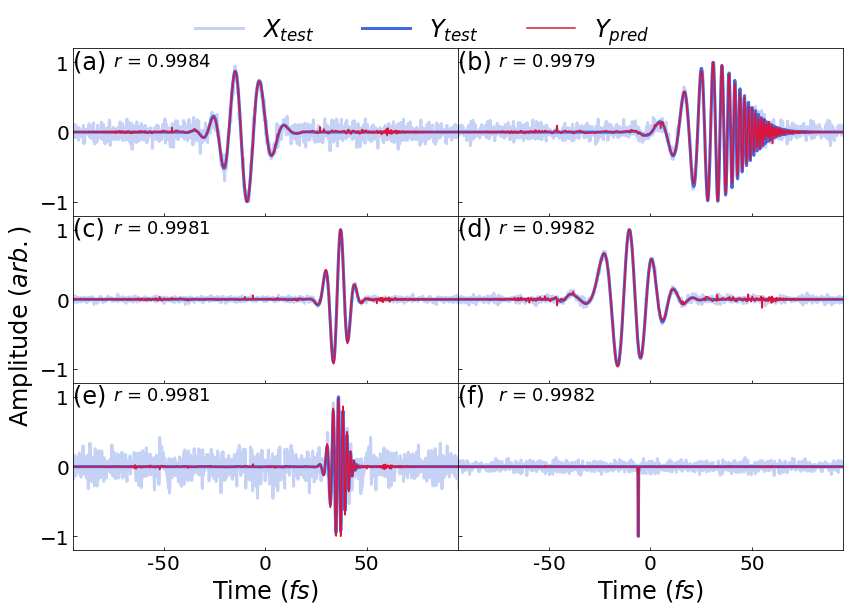

In [11]:
fig, axs = plt.subplots(3, 2, figsize=(12,8), sharex=True, sharey=True, gridspec_kw = {'wspace':0, 'hspace':0})


import random
from matplotlib.ticker import FormatStrFormatter

corri = tfp.stats.correlation(y_pred_reverted.astype('float64'), y_test_reverted.astype('float64'), sample_axis=1, event_axis=None)

axs = axs.ravel()
for i in range(6):
    j = random.choice(range(len(y_pred_reverted)))
   
    axs[i].plot(df_time['Time (fs)'], norm(X_test_reverted[j, :].transpose()), linewidth=3, color='royalblue', alpha=0.3)
    axs[i].plot(df_time['Time (fs)'], norm(y_test_reverted[j, :].transpose()), linestyle='-',linewidth=3, color='royalblue')
    axs[i].plot(df_time['Time (fs)'], norm(y_pred_reverted[j, :].transpose()), linestyle='-', linewidth=1.5, color='crimson')
    axs[i].set_xlabel('Time ($fs$)', fontsize=24)
    axs[i].set_xlim(-95,95)
    axs[i].set_ylim(-1.2,1.2)
    axs[i].tick_params('both', labelsize=20, direction='in')
    axs[i].text(-75,0.95, '$r$ = %1.4f' %(corri[j].numpy()), fontsize=18)
    axs[i].set_xticklabels([-100, -50, 0, 50, 100])
    fig_title = ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)']
    axs[i].set_title(fig_title[i], fontsize=24, loc='left', y=1.0, pad=-20)


fig.legend(['$X_{test}$', '$Y_{{test}}$', '$Y_{{pred}}$', ], loc='upper center', bbox_to_anchor=(0.5, 1.075), frameon=False, fontsize=24, ncol=3)
fig.supylabel('Amplitude ($arb.$)', fontsize=24)

plt.tight_layout()
plt.show()

# COMPARE MODEL PERFORMANCE WITH WAVELET TRANSFORM AND WIENER TRANSFORM

In [12]:
import pywt
from scipy.signal import wiener


wavelet = pywt.Wavelet('sym8')
level = 2

denoised_signal_arr = np.zeros((6400,1000))
noise_mean_WL = np.zeros(6400)
noise_mean_ML = np.zeros(6400)
noise_mean_wiener = np.zeros(6400)
WL_FFT = np.zeros((6400,1000))

for k in range(6400):
    noisy_signal = X_test_reverted[k, :]
    coefficients = pywt.wavedec(noisy_signal, wavelet, level=level)
    for i in range(1, level+1):
        coefficients[i] = pywt.threshold(coefficients[i], np.std(coefficients[i])*2, mode='soft')
    denoised_signal = pywt.waverec(coefficients, wavelet)

    denoised_signal_arr[k] = denoised_signal


    WL_FFT[k] = np.fft.fft(denoised_signal)
    noise_mean_wiener[k] = np.mean((norm(y_test_reverted[k, :].transpose())-norm(wiener(noisy_signal)))**2)
    noise_mean_WL[k] = np.mean((norm(y_test_reverted[k, :].transpose())-norm(denoised_signal))**2)
    noise_mean_ML[k] = np.mean((norm(y_test_reverted[k, :].transpose())-norm(y_pred_reverted[k, :].transpose()))**2)

/var/folders/l2/zgmv_2g55wbf1wpzk7lhns_w0000gn/T/ipykernel_15167/541578095.py:25: ComplexWarning: Casting complex values to real discards the imaginary part
  WL_FFT[k] = np.fft.fft(denoised_signal)


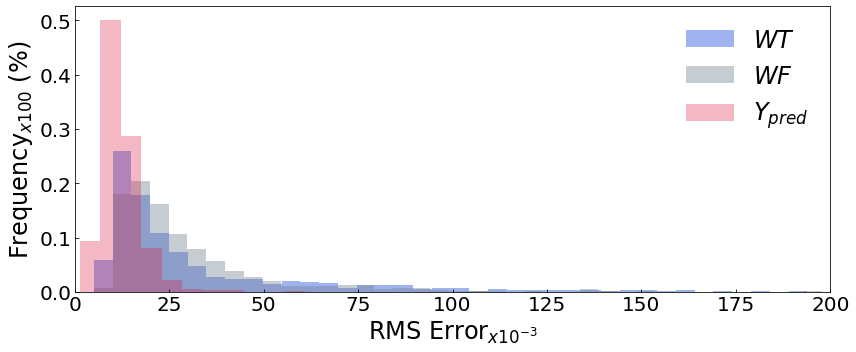

In [13]:
WL_mu, WL_std = scipy.stats.norm.fit(np.sqrt(noise_mean_WL))
ML_mu, ML_std = scipy.stats.norm.fit(np.sqrt(noise_mean_ML))

fig, axs = plt.subplots(figsize=(12,5))

plt.hist(np.sqrt(noise_mean_WL), bins=75, density=False, alpha=0.5, color='royalblue', stacked=True, weights=np.ones(len(noise_mean_WL))/len(noise_mean_WL))
plt.hist(np.sqrt(noise_mean_wiener), bins=75, density=False, alpha=0.4, color='slategray', stacked=True, weights=np.ones(len(noise_mean_wiener))/len(noise_mean_wiener))
plt.hist(np.sqrt(noise_mean_ML), bins=11, density=False, alpha=0.3, color='crimson', stacked=True, weights=np.ones(len(noise_mean_ML))/len(noise_mean_ML))


plt.ylabel('Frequency (%)', fontsize=24)
plt.xlabel('RMS Error$_{x10^{-3}}$', fontsize=24)
plt.tick_params('both', labelsize=20, direction='in')

plt.legend(['$WT$', '$WF$','$Y_{{pred}}$'], loc='upper right', frameon=False, fontsize=24, ncol=1)


plt.xlim(0, 200)
plt.ylim(0, None)
plt.tight_layout()

plt.show()

/var/folders/l2/zgmv_2g55wbf1wpzk7lhns_w0000gn/T/ipykernel_15167/2237429742.py:35: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0, None)


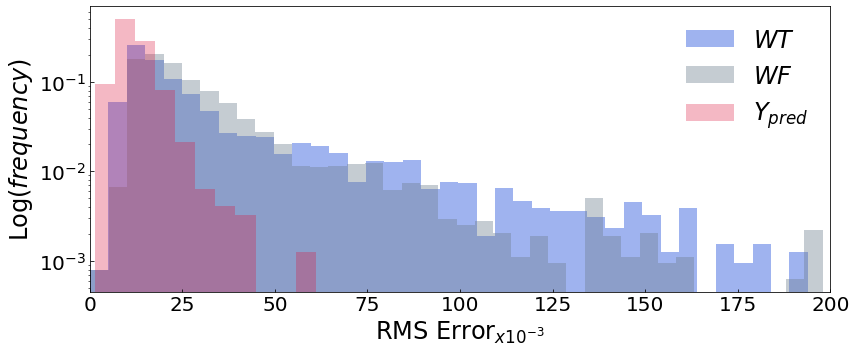

In [14]:
WL_mu, WL_std = scipy.stats.norm.fit(np.sqrt(noise_mean_WL))
ML_mu, ML_std = scipy.stats.norm.fit(np.sqrt(noise_mean_ML))

fig, axs = plt.subplots(figsize=(12,5))

plt.hist(np.sqrt(noise_mean_WL), bins=75, log=True, density=False, alpha=0.5, color='royalblue', stacked=True, weights=np.ones(len(noise_mean_WL))/len(noise_mean_WL))
plt.hist(np.sqrt(noise_mean_wiener), bins=75, log=True, density=False, alpha=0.4, color='slategray', stacked=True, weights=np.ones(len(noise_mean_wiener))/len(noise_mean_wiener))
plt.hist(np.sqrt(noise_mean_ML), bins=11, log=True, density=False, alpha=0.3, color='crimson', stacked=True, weights=np.ones(len(noise_mean_ML))/len(noise_mean_ML))

plt.ylabel('Log($frequency$)', fontsize=24)
plt.xlabel('RMS Error$_{x10^{-3}}$', fontsize=24)

plt.tick_params('both', labelsize=20, direction='in')

from matplotlib.ticker import PercentFormatter, LogitFormatter,LogFormatterSciNotation

plt.legend(['$WT$', '$WF$','$Y_{{pred}}$'], loc='upper right', frameon=False, fontsize=24, ncol=1)
plt.xlim(0, 200)
plt.ylim(0, None)
plt.tight_layout()


plt.show()